# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow.keras.models as models
import seaborn as sns
from keras.regularizers import l2
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.4.1'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
# train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
#                                    featurewise_std_normalization = True,width_shift_range=0.2,
#                                    height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
#                                    zca_whitening = True,channel_shift_range = 20,
#                                    horizontal_flip = True,vertical_flip = True,
#                                    validation_split = 0.2,fill_mode='constant')

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
model = Sequential()
layer1 = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape = (224,224,3), classes=4)
# layer1.trainable = False

numToFreeze = 300
for layer in layer1.layers[:numToFreeze]:
    layer1.trainable = False



model.add(layer1)
model.add(tf.keras.layers.BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu',name = 'densefn'))
model.add(Dropout(0.3))

model.add(Dense(4))
model.add(tf.keras.layers.Activation('softmax'))
model.build(input_shape=(None, 224, 224, 3))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
batch_normalization_94 (Batc (None, 5, 5, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
densefn (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
_________________________________________________________________
activation_94 (Activation)   (None, 4)                 0

#### [5 points] Train Model

In [5]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)


22
6
21
5


In [6]:
opt = tf.optimizers.Adam(learning_rate=1e-3)
lossfn = 'categorical_crossentropy'

model.compile(optimizer=opt,
                loss=lossfn,
                metrics=['accuracy'])


In [7]:
start = time.time()
history = model.fit(
    x = train_batches, 
    epochs=100, 
    validation_data= valid_batches, 
    steps_per_epoch = 10,
    batch_size=10,
    validation_steps = STEP_SIZE_VALID
)
end = time.time()


c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
10/10 [==============================] - 20s 1s/step - loss: 11.1861 - accuracy: 0.2921 - val_loss: 17.8603 - val_accuracy: 0.4400
Epoch 2/100
10/10 [==============================] - 9s 885ms/step - loss: 6.7030 - accuracy: 0.5457 - val_loss: 13.3293 - val_accuracy: 0.5800
Epoch 3/100
10/10 [==============================] - 9s 900ms/step - loss: 6.6563 - accuracy: 0.5228 - val_loss: 15.4814 - val_accuracy: 0.4400
Epoch 4/100
10/10 [==============================] - 13s 1s/step - loss: 8.1831 - accuracy: 0.5361 - val_loss: 11.3597 - val_accuracy: 0.5400
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 3.4756 - accuracy: 0.5925 - val_loss: 8.0664 - val_accuracy: 0.4600
Epoch 6/100
10/10 [==============================] - 13s 1s/step - loss: 2.4449 - accuracy: 0.6740 - val_loss: 6.7060 - val_accuracy: 0.5400
Epoch 7/100
10/10 [==============================] - 14s 1s/step - loss: 1.7772 - accuracy: 0.6963 - val_loss: 4.8884 - val_accuracy: 0.6000
Epoc

10/10 [==============================] - 8s 816ms/step - loss: 1.1121 - accuracy: 0.6889 - val_loss: 1.0416 - val_accuracy: 0.6000
Epoch 59/100
10/10 [==============================] - 7s 740ms/step - loss: 0.8823 - accuracy: 0.6260 - val_loss: 0.9657 - val_accuracy: 0.6200
Epoch 60/100
10/10 [==============================] - 8s 805ms/step - loss: 0.9060 - accuracy: 0.6702 - val_loss: 0.8714 - val_accuracy: 0.6600
Epoch 61/100
10/10 [==============================] - 9s 969ms/step - loss: 1.2807 - accuracy: 0.7335 - val_loss: 1.4239 - val_accuracy: 0.6400
Epoch 62/100
10/10 [==============================] - 12s 1s/step - loss: 0.7088 - accuracy: 0.6484 - val_loss: 0.9459 - val_accuracy: 0.6800
Epoch 63/100
10/10 [==============================] - 9s 941ms/step - loss: 0.9136 - accuracy: 0.6712 - val_loss: 0.8294 - val_accuracy: 0.6800
Epoch 64/100
10/10 [==============================] - 11s 1s/step - loss: 0.9343 - accuracy: 0.6112 - val_loss: 0.9656 - val_accuracy: 0.5400
Epoch 65/

In [8]:
print("Model RunTime (seconds):",end - start)

Model RunTime (seconds): 1060.2564942836761


#### [5 points] Plot Accuracy and Loss During Training

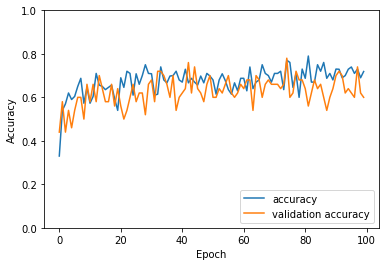

In [9]:
import matplotlib.pyplot as plt

#raise NotImplementedError("Plot the accuracy and the loss during training")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

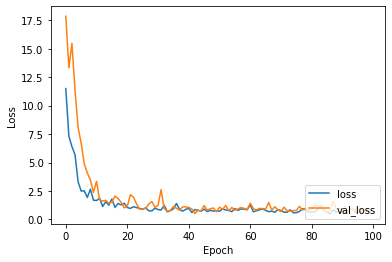

In [10]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#### Testing Model

In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36


c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


36/36 [==============================] - 3s 78ms/step - loss: 1.5781 - accuracy: 0.7500 0s - loss: 1.0712 - accu
Test loss: 1.5781127214431763
Test accuracy: 0.75


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [12]:
intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('densefn').output)
tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")


intermediate_layer_model.summary()

Found 270 images belonging to 4 classes.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3_input (InputLay [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
batch_normalization_94 (Batc (None, 5, 5, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
densefn (Dense)              (None, 256)               13107456  
Total params: 34,918,432
Trainable params: 13,111,552
Non-trainable params: 21,806,880
_________________________________________________________________


In [13]:
outputs = intermediate_layer_model.predict(tsne_eval_generator)
predictions = model.predict(tsne_eval_generator)
tsne = TSNE(n_components=2, verbose=1)
tsne_proj = tsne.fit_transform(outputs)
pred_value = []
for i in range(len(predictions)):
    pred_value.append(np.argmax(predictions[i]))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 270 samples in 0.000s...
[t-SNE] Computed neighbors for 270 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 270 / 270
[t-SNE] Mean sigma: 28.250594
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.441231
[t-SNE] KL divergence after 1000 iterations: 0.533138


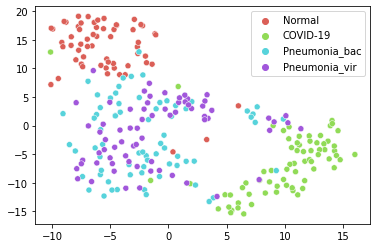

In [14]:
c = tsne_eval_generator.labels

scat=sns.scatterplot(x=tsne_proj[:,0],y=tsne_proj[:,1], hue=c, palette=sns.color_palette("hls",4))
handles, labels = scat.get_legend_handles_labels()
scat.legend(handles, ['Normal', 'COVID-19','Pneumonia_bac', 'Pneumonia_vir'])